In [1]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot as plt

def RMSLE(pred1,pred2,true1,true2):
    pred1 = np.array(pred1)
    pred2 = np.array(pred2)
    true1 = np.array(true1)
    true2 = np.array(true2)
    error1 = np.square(np.log(pred1 + 1) - np.log(true1 + 1)).mean()**0.5
    error2 = np.square(np.log(pred2 + 1) - np.log(true2 + 1)).mean()**0.5
    return np.sum(error1 + error2)/2

In [2]:
### Prepare data

train = pd.read_csv(os.path.join("data", "train.csv"))  
test = pd.read_csv(os.path.join("data", "test.csv"))
train_size = train.shape
test_size = test.shape
validation_index = int(0.8 * train_size[0])


data_no_id = train.drop(["id"], axis=1)
X = train.drop(["id", 'formation_energy_ev_natom', 'bandgap_energy_ev'], axis=1)
Y1 = train['formation_energy_ev_natom']
Y2 = train['bandgap_energy_ev']

trainX = X[:validation_index]
validationX = X.iloc[validation_index:]
testX = test.drop(["id"], axis=1)
trainY1 = Y1[:validation_index]
trainY2 = Y2[:validation_index]
validationY1 = Y1[validation_index:]
validationY2 = Y2[validation_index:]

print(f"Number of training data ==> X: {trainX.shape[0]}, Y1: {trainY1.shape[0]}, Y2: {trainY2.shape[0]}")
print(f"Number of validation data ==> X: {validationX.shape[0]}, Y1: {validationY1.shape[0]}, Y2: {validationY2.shape[0]}")
print(f"Number of test data ==> X: {testX.shape[0]}")

Number of training data ==> X: 1920, Y1: 1920, Y2: 1920
Number of validation data ==> X: 480, Y1: 480, Y2: 480
Number of test data ==> X: 600


In [3]:
### Find best ridge penalty term

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

ridge_model = Ridge()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = np.arange(0.01, 4, 0.01)
search = GridSearchCV(ridge_model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(trainX, trainY1)
# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

best_alpha = results.best_params_['alpha']

MSE: -0.007
Config: {'alpha': 1.58}


In [4]:
### Fit the best ridge model

ridge_model = Ridge(best_alpha)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
y_pred = cross_val_predict(ridge_model, trainX, trainY1)
diff = trainY1 - y_pred
mean = diff.mean()                                                             # sample mean
S = S = np.std(diff, ddof=1)                                                   # sample std. dev
mse = np.sum(diff ** 2) / len(y_pred)
print(f"{mean:.6f} +- {S:.6f} ===> {mse}")

# Find 95% confidence level
Cl = mean - 2 * S
Ct = mean + 2 * S
print('{} <= X <= {}'.format(Cl, Ct))

# Separate good values (inside confidence interval) from noise (outside confidence interval)
diffs_95 = diff[(diff > Cl) & (diff < Ct)]
diffs_noise = diff[(diff <= Cl) | (diff >= Ct)]

-0.000028 +- 0.081600 ===> 0.006655096310414805
-0.16322817701387815 <= X <= 0.16317190927861075


In [8]:
### Find best lasso penalty

lasso_model = Lasso()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = np.arange(0.02, 10, 0.02)
search = GridSearchCV(lasso_model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(trainX, trainY1)
# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

best_alpha = results.best_params_['alpha']

MSE: -0.008
Config: {'alpha': 0.02}


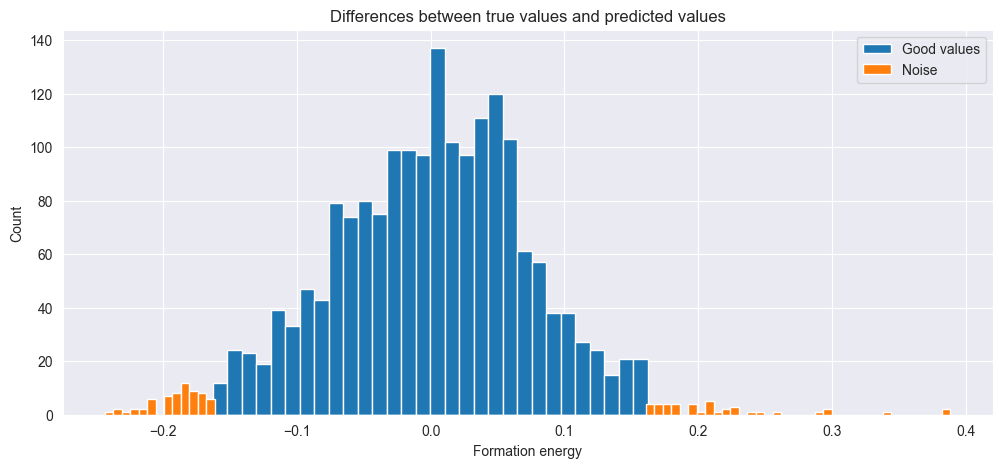

In [5]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(12,5))
plt.hist(diffs_95, bins=30, label="Good values")
plt.hist(diffs_noise, bins=100, label="Noise")
plt.title("Differences between true values and predicted values")
plt.xlabel("Formation energy")
plt.ylabel("Count")
plt.legend()
plt.show()

In [6]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(trainX, trainY1)

y_pred_lr = regr.predict(validationX)
mse_lr = np.sum( (validationY1 - y_pred_lr) ** 2 ) / len(validationY1)
train_score_lr = regr.score(trainX, trainY1)
test_score_lr = regr.score(validationX, validationY1)
print(f"MSE LR: {mse_lr}")
print("Scores: ", train_score_lr, " - ", test_score_lr, "\n")

ridge_model.fit(trainX, trainY1)
y_pred_ridge = ridge_model.predict(validationX)
mse_ridge = np.sum( (validationY1 - y_pred_ridge) ** 2 ) / len(validationY1)
train_score_ridge = ridge_model.score(trainX, trainY1)
test_score_ridge = ridge_model.score(validationX, validationY1)
print(f"MSE Ridge: {mse_ridge}")
print("Scores: ", train_score_ridge, " - ", test_score_ridge)

MSE LR: 0.00657249775412318
Scores:  0.3853147822163745  -  0.4362615168017049 

MSE Ridge: 0.006634010966345179
Scores:  0.3819106590948347  -  0.4309853849182166
